<a href="https://colab.research.google.com/github/Rishika-Maharjan/MLPC_Individual/blob/main/MLPC_Individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost --quiet

# **Loading Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# Loading the dataset
df = pd.read_csv("/content/fire_archive_V1_96617[1].csv")
print(" Dataset Loaded")
print(df.head())

 Dataset Loaded
   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0 -34.45902  150.88040       326.5  0.60   0.71  2019-08-01       246   
1 -31.70724  151.07191       367.0  0.56   0.69  2019-08-01       247   
2 -31.39626  149.65253       325.2  0.68   0.74  2019-08-01       247   
3 -30.39774  152.06432       347.8  0.48   0.65  2019-08-01       247   
4 -31.20248  151.89766       350.7  0.50   0.66  2019-08-01       247   

  satellite instrument confidence  version  bright_ti5   frp  type  
0         N      VIIRS          n        1       290.7   5.8     3  
1         N      VIIRS          h        1       291.9  10.4     0  
2         N      VIIRS          n        1       292.7   5.6     0  
3         N      VIIRS          n        1       287.6   9.1     0  
4         N      VIIRS          n        1       292.3   9.4     0  


# **Data Preprocessing**

In [ ]:
# Checking for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
latitude      0
longitude     0
bright_ti4    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_ti5    0
frp           0
type          0
dtype: int64


In [ ]:
# Showing Basic data description
df.describe()

,latitude,longitude,bright_ti4,scan,track,acq_time,version,bright_ti5,frp,type
count,184778.000000,184778.000000,184778.000000,184778.000000,184778.000000,184778.000000,184778.0,184778.000000,184778.000000,184778.000000
mean,-19.685348,139.745804,331.579243,0.462866,0.487535,899.196939,1.0,297.618382,8.631552,0.064894
std,7.406026,9.538529,20.761619,0.090993,0.117488,564.545266,0.0,12.022101,15.959307,0.412289
min,-43.079850,114.111350,208.000000,0.320000,0.360000,229.000000,1.0,253.400000,0.100000,0.000000
25%,-28.163370,131.393725,310.900000,0.390000,0.380000,415.000000,1.0,288.200000,1.800000,0.000000
50%,-16.206520,141.559265,335.900000,0.440000,0.450000,511.000000,1.0,296.400000,4.500000,0.000000
75%,-13.543725,150.231905,346.700000,0.520000,0.570000,1528.000000,1.0,306.800000,9.000000,0.000000
max,-9.394060,153.521120,367.000000,0.800000,0.780000,1827.000000,1.0,380.000000,595.200000,3.000000


In [ ]:
# Data information of data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184778 entries, 0 to 184777
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    184778 non-null  float64
 1   longitude   184778 non-null  float64
 2   bright_ti4  184778 non-null  float64
 3   scan        184778 non-null  float64
 4   track       184778 non-null  float64
 5   acq_date    184778 non-null  object 
 6   acq_time    184778 non-null  int64  
 7   satellite   184778 non-null  object 
 8   instrument  184778 non-null  object 
 9   confidence  184778 non-null  object 
 10  version     184778 non-null  int64  
 11  bright_ti5  184778 non-null  float64
 12  frp         184778 non-null  float64
 13  type        184778 non-null  int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 19.7+ MB


In [ ]:
# Selecting key features
df = df[['latitude', 'longitude', 'bright_ti4', 'bright_ti5', 'scan', 'track', 'acq_date',
        'acq_time', 'confidence', 'version', 'frp']]

**Data** **Transformation**

In [ ]:
# Converting confidence to lower case
df['confidence'] = df['confidence'].str.lower()
# Binary classification: if confidence is high or nominal => fire (1), else no fire (0)
df['fire_label'] = df['confidence'].apply(lambda x: 1 if x in ['h', 'n'] else 0)

In [ ]:
# Converting the date and time fields
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Extracting hour from 4 digit time string
df['hour'] = df['acq_time'].astype(str).str.zfill(4).str[:2].astype(int)

**Data Reduction**

In [ ]:
# Droping unused fields
df.drop(columns=['confidence', 'version', 'acq_time'], inplace=True)

In [ ]:
# Droping missing values (if any)
df = df.dropna()

**Feature Engineering**

In [ ]:
df['day'] = df['acq_date'].dt.day
df['month'] = df['acq_date'].dt.month
df['year'] = df['acq_date'].dt.year

In [ ]:
#Spliting into features and target
df = df.drop(columns=['acq_date'])
X = df.drop(columns=['fire_label'])
y = df['fire_label']

**Scaling**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Preprocessing completed. Training samples:", X_train.shape[0], "| Testing samples:", X_test.shape[0])

Preprocessing completed. Training samples: 147822 | Testing samples: 36956


# EDA

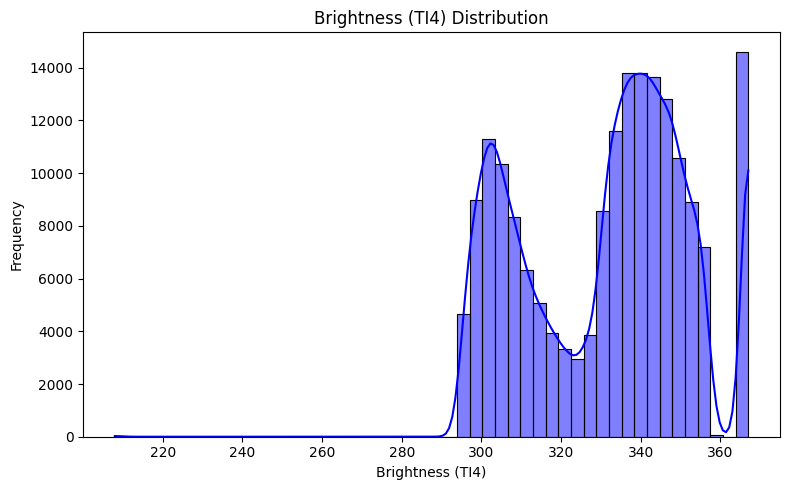

In [ ]:
#  Brightness histogram
plt.figure(figsize=(8,5))
sns.histplot(df['bright_ti4'], bins=50, kde=True, color='Blue')
plt.title('Brightness (TI4) Distribution')
plt.xlabel('Brightness (TI4)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

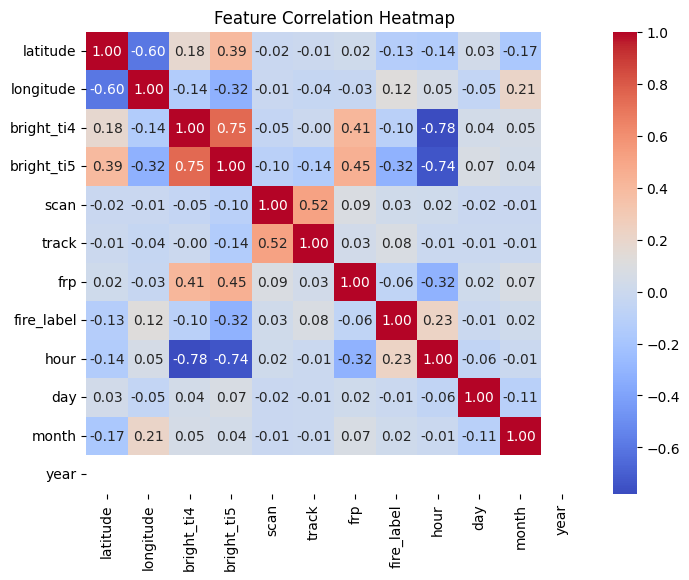

In [ ]:
# Correlation
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

/tmp/ipython-input-17-2439203432.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fire_label', data=df, palette='Set2')


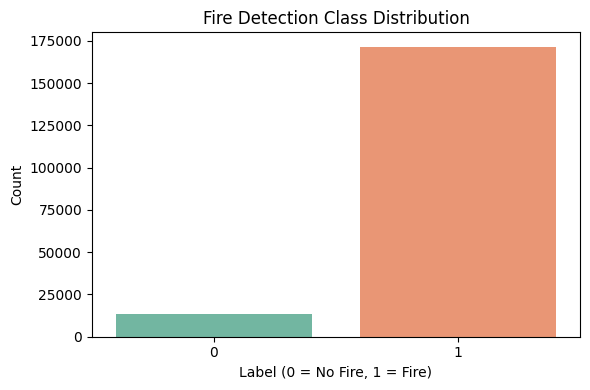

In [ ]:
#  Fire label distribution where 0 indicates no fire and 1 indicates fire
plt.figure(figsize=(6,4))
sns.countplot(x='fire_label', data=df, palette='Set2')
plt.title("Fire Detection Class Distribution")
plt.xlabel("Label (0 = No Fire, 1 = Fire)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


/tmp/ipython-input-18-1539468243.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='flare')


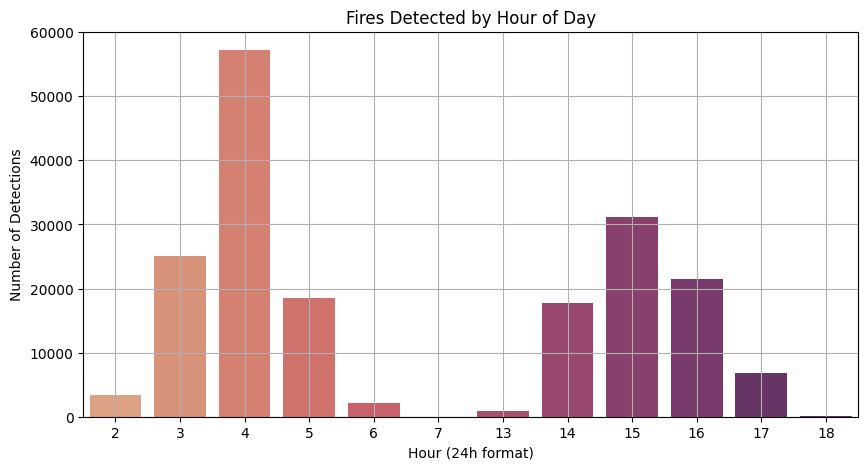

In [ ]:
# Countplot
plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df, palette='flare')
plt.title("Fires Detected by Hour of Day")
plt.xlabel("Hour (24h format)")
plt.ylabel("Number of Detections")
plt.grid(True)
plt.show()

# **Model** Training Strategy & Parallel Computing Technique

In [ ]:
# Random Forest Non-Parallel CPU (Single-threaded RandomForest)
start_cpu_np_train = time.time()
rf_np = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
rf_np.fit(X_train, y_train)
end_cpu_np_train = time.time()

start_cpu_np_pred = time.time()
y_pred_np = rf_np.predict(X_test)
end_cpu_np_pred = time.time()

cpu_np_train_time = end_cpu_np_train - start_cpu_np_train
cpu_np_pred_time = end_cpu_np_pred - start_cpu_np_pred

print("Non-Parallel Random Forest (CPU only)")
print(f"Training Time: {cpu_np_train_time:.4f} s")
print(f"Prediction Time: {cpu_np_pred_time:.4f} s")
print(f"Accuracy: {accuracy_score(y_test, y_pred_np):.4f}")
print(classification_report(y_test, y_pred_np))

Non-Parallel Random Forest (CPU only)
Training Time: 18.6166 s
Prediction Time: 0.2989 s
Accuracy: 0.9690
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2723
           1       0.98      0.98      0.98     34233

    accuracy                           0.97     36956
   macro avg       0.89      0.88      0.89     36956
weighted avg       0.97      0.97      0.97     36956



In [ ]:
# Random forest parallel training with multithreading(n_jobs=-1)
start_train = time.time()
rf_parallel = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_parallel.fit(X_train, y_train)
end_train = time.time()

y_pred_parallel = rf_parallel.predict(X_test)
parallel_acc = accuracy_score(y_test, y_pred_parallel)
parallel_time = end_train - start_train

print("RandomForest (Parallel CPU)")
print(f"Accuracy: {parallel_acc:.4f}")
print(f"Training Time: {parallel_time:.4f} s")
print(classification_report(y_test, y_pred_parallel))

RandomForest (Parallel CPU)
Accuracy: 0.9690
Training Time: 16.7944 s
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2723
           1       0.98      0.98      0.98     34233

    accuracy                           0.97     36956
   macro avg       0.89      0.88      0.89     36956
weighted avg       0.97      0.97      0.97     36956



In [ ]:
# Train XGBoost with GPU
start_gpu_train  = time.time()
model_gpu = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', random_state=42, verbosity=0)
model_gpu.fit(X_train, y_train)
end_gpu_train = time.time()

start_gpu_pred = time.time()
pred_gpu = model_gpu.predict(X_test)
end_gpu_pred = time.time()

gpu_train_time = end_gpu_train - start_gpu_train
gpu_pred_time = end_gpu_pred - start_gpu_pred

print("\nGPU Model:")
print("Training Time:", round(gpu_train_time, 2), "s")
print("Prediction Time:", round(gpu_pred_time, 4), "s")
print("Accuracy:", accuracy_score(y_test, pred_gpu))
print(classification_report(y_test, pred_gpu))


GPU Model:
Training Time: 0.92 s
Prediction Time: 0.0485 s
Accuracy: 0.9710195908648122
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2723
           1       0.99      0.98      0.98     34233

    accuracy                           0.97     36956
   macro avg       0.88      0.91      0.90     36956
weighted avg       0.97      0.97      0.97     36956



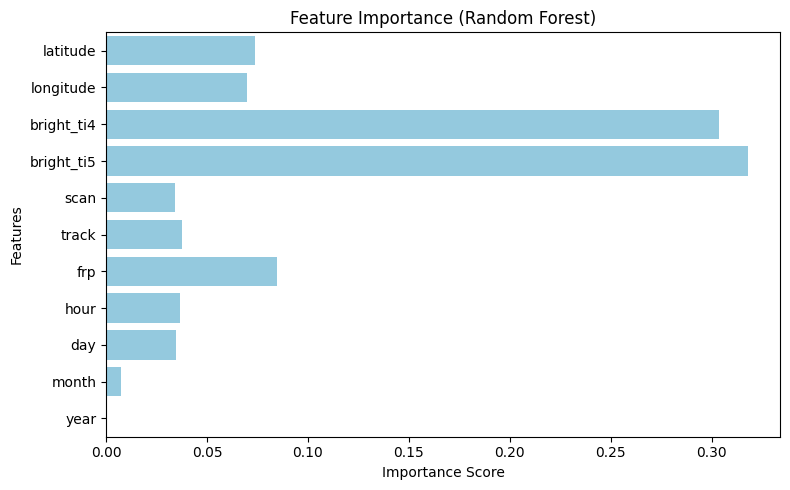

In [ ]:
# Ploting the top feature importances from Random Forest
importances = rf_parallel.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, color='skyblue')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

**Comparison of the models**

In [ ]:
# All the Comparison of the models
results = {
    "Non-Parallel CPU": {
        "accuracy": accuracy_score(y_test, y_pred_np),
        "training_time": cpu_np_train_time

    },
    "Parallel CPU": {
        "accuracy": accuracy_score(y_test, rf_parallel.predict(X_test)),
        "training_time": parallel_time
    },
    "GPU (XGBoost)": {
        "accuracy": accuracy_score(y_test, pred_gpu),
        "training_time": gpu_train_time
    }
}

# Printing Accuracy and Training Time for All
print("\nAccuracy and Training Time of models")
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'Accuracy', 'Training Time (s)']
results_df.sort_values(by="Accuracy", inplace=True)
results_df


Accuracy and Training Time of models


,Model,Accuracy,Training Time (s)
0,Non-Parallel CPU,0.96899,18.616577
1,Parallel CPU,0.96899,16.794399
2,GPU (XGBoost),0.97102,0.924247


In [ ]:
# Determining the best model according to the accuracy
best_model = max(results, key=lambda k: results[k]["accuracy"])
best_acc = results[best_model]["accuracy"]

print("Conclusion :")
print(f"Most Accurate Model: {best_model} ({best_acc:.4f})")

Conclusion :
Most Accurate Model: GPU (XGBoost) (0.9710)


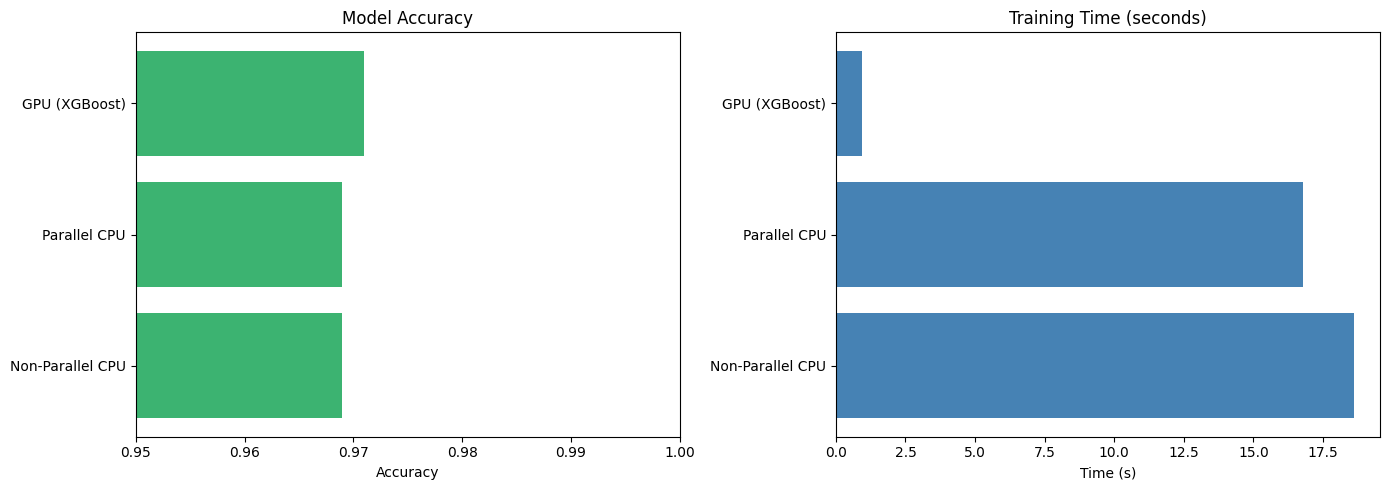

In [ ]:
# Visual representation of the results

# Writing Model Names, Accuracy, and Training Time
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
train_times = [results[m]['training_time'] for m in model_names]

# Setting the style
plt.style.use('seaborn-v0_8-colorblind')

# Creating side-by-side bar plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Bar Plot
axs[0].barh(model_names, accuracies, color='mediumseagreen')
axs[0].set_title("Model Accuracy")
axs[0].set_xlabel("Accuracy")
axs[0].set_xlim([0.95, 1.0])

# Training Time Bar Plot
axs[1].barh(model_names, train_times, color='steelblue')
axs[1].set_title("Training Time (seconds)")
axs[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


In [ ]:
# Visualizatiing Actual and Predicted labels

X_test_df['Actual'] = y_test.values
X_test_df['CPU_Pred'] = y_pred_np
X_test_df['GPU_Pred'] = pred_gpu

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, title in zip(
    axs,
    ['Actual', 'CPU_Pred', 'GPU_Pred'],
    ['Actual Labels', 'CPU Predictions (RF)', 'GPU Predictions (XGBoost)']
):
    sns.scatterplot(data=X_test_df, x='longitude', y='latitude', hue=col,
                    palette={0: 'green', 1: 'red'}, alpha=0.5, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(title='Label')

plt.suptitle("Scatter Plot: Actual vs Predicted Fire Locations", fontsize=16)
plt.tight_layout()
plt.show()